# Question 1-12

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
import time
from tqdm import tqdm
from surprise.model_selection import KFold
from surprise import accuracy
import operator
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
import csv
from collections import Counter
from surprise import AlgoBase
from sklearn.metrics import roc_auc_score


def trimming(testset, domain):
    trimmed_testset= []
    for i in range(len(testset)):
        if int(testset[i][1]) in domain:
            trimmed_testset.append(testset[i])
    return trimmed_testset


def trimmed_rmse_plot(trimming, k, domain, filename, data, save_flag=True):
    cv = KFold(n_splits=10)
    avg_rmse = []
    for i in tqdm(k):
        rmse = []
        for trainset, testset in cv.split(data):
            trimmed_testset = trimming(testset, domain)
            knn = KNNWithMeans(k=i, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
            knn.fit(trainset)
            predictions = knn.test(trimmed_testset)
            rmse.append(accuracy.rmse(predictions, verbose=False))
        avg_rmse.append(np.mean(rmse))
    plt.figure()
    plt.plot(k, avg_rmse)
    plt.title("Average RMSE for KNN with " + filename)
    plt.xlabel("k")
    plt.ylabel("Average RMSE")
    plt.grid()
    if save_flag:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    print("Minimum Average RMSE for "+ filename + " is:\n", min(avg_rmse))


def plot_roc_curve(testset, fname, model, save_flag=True):
    predictions = model.test(testset)
    thresholds = [2.5, 3, 3.5, 4]
    for i in thresholds:
        y_true = [1 if row[2] > i else 0 for row in predictions]
        y_pred = [row[3] for row in predictions]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, label= 'AUC with threshold {} = %0.3f'.format(str(i)) % roc_auc)
        plt.title(fname)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.grid()
        plt.legend()
    if save_flag:
        plt.savefig(fname=fname, dpi=300, bbox_inches='tight')
    plt.show()


### <strong>Question 1: Explore the Dataset </strong>

#### A. Compute the sparsity of the movie rating dataset:
<p>The sparsity of the movie rating dataset is computed as only 0.016999683055613623, indicating plenty of items are missing rating information.</p>

In [ ]:
ratings = pd.read_csv("ratings.csv")
num_users = len(ratings["userId"].drop_duplicates())
num_movies = len(ratings["movieId"].drop_duplicates())
num_avai_ratgs = len(ratings["rating"])
sparsity = num_avai_ratgs / (num_users * num_movies)

print(f"The Sparsity of the movie rating dataset:\n{sparsity}" )

The Sparsity of the movie rating dataset:
0.016999683055613623


#### B. Plot a histogram showing the frequency of the rating values, and comment on the shape of the histogram
<p>As shown in the histogram below, a very limited number of items receive extreme low ratings (<em>e.g.</em>, 0.5, 1.0, 1.5), and majority of items receives ratings above 3.0. The histogram tilted to the right in terms of shape. Users give 4.0 most frequently, followed by 3.0 and 5.0. It may suggest that users tend to give positive feedbacks to these items. The second cell below summaries the exact frequency of each rating.</p>

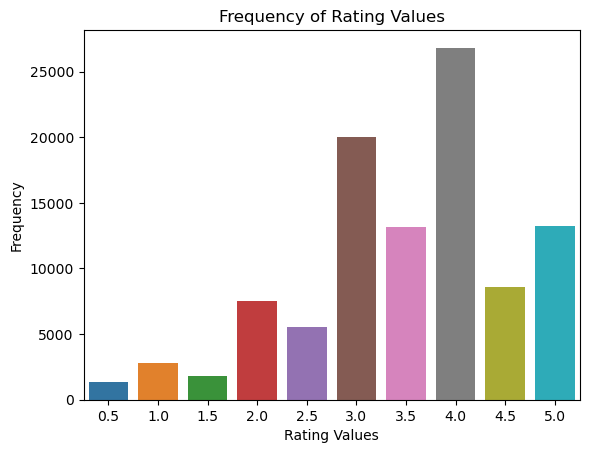

In [ ]:
rating_count = ratings["rating"].value_counts()
sns.barplot(x = rating_count.index, y=rating_count.values)
plt.title("Frequency of Rating Values")
plt.xlabel("Rating Values")
plt.ylabel("Frequency")
plt.savefig("1-Frequency of Rating Values", dpi=300, bbox_inches="tight")

In [ ]:
rating_count

4.0    26816
3.0    20046
5.0    13211
3.5    13136
4.5     8553
2.0     7551
2.5     5551
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

#### C. Plot the distribution of the number of ratings received among movies
<p>As shown in the plot below, the number of ratings per item received distributed HIGHLY IMBALANCED among items. It could be that one item received ratings over 300 times, and simultaneously almost 40% (from slighly over 6000 to almost 10000 in terms of index ranging from 0 to 10000) items received very few number of ratings.</p>

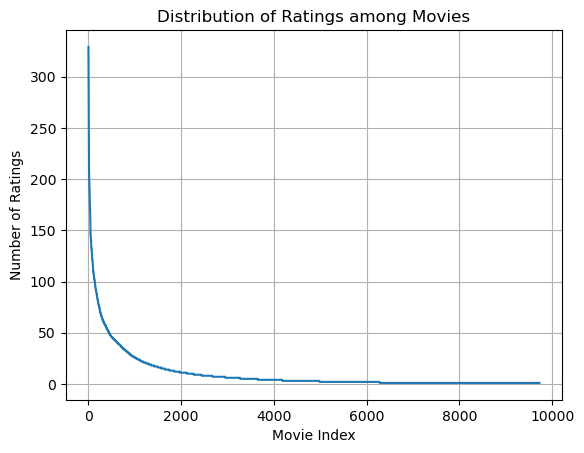

In [ ]:
plt.plot(sorted(ratings["movieId"].value_counts(),reverse=True))
plt.xlabel("Movie Index")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings among Movies")
plt.grid()
plt.savefig("2-Distribution of Ratings among Movies", dpi=300, bbox_inches="tight")

#### D. Plot the distribution of ratings among users
<p>As shown in the plot below, the number of ratings per user gave distributed HIGHLY IMBALANCED among users. Some individuals are very keen on rating and gave over 2500 ratings; while about 1/3 of users gave less than 100 ratings.</p>

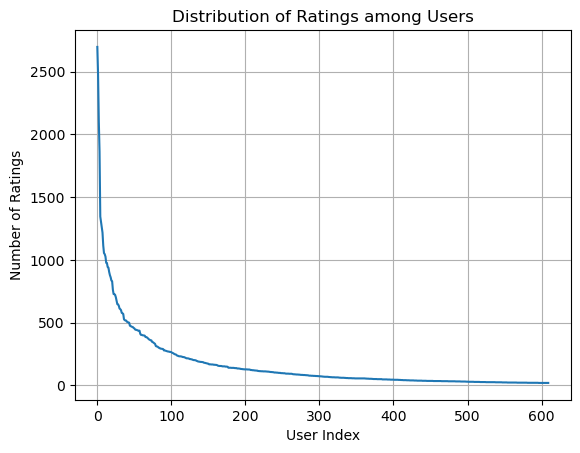

In [ ]:
plt.plot(sorted(ratings["userId"].value_counts(),reverse=True))
plt.xlabel("User Index")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings among Users")
plt.grid()
plt.savefig("3-Distribution of Ratings among Users", dpi=300, bbox_inches="tight")

#### E. Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.
<p>(1) The result of Question C tells us that the number of ratings per item received distributed HIGHLY IMBALANCED among items. Only a small number of items received substantial amount of ratings as good reference for the recommendation system, while almost 40% items received very few number of ratings. It makes sense intuitively that popular items are usually watched and thus rated significantly more than less popular ones. This obervation leads to that the recommendation system may tend to recommend popular items.</p>
<p>(2) The result of Question D tells us that the number of ratings per user gave distributed HIGHLY IMBALANCED among users. Some individuals are very keen on rating and gave over 2500 ratings; while about 1/3 of users are indifferent on rating and gave less than 100 ratings. As a result, the recommendation tends to be greatly swayed by the opinion of the minority users who gave ratings.</p>

#### F. Compute the variance of the rating values received by each movie, and briefly comment on the shape of the resulting histogram.
<p>As observed by the plot on Variance of Rating Values, more than 50% of items received ratings on which variance is less than 1.0, and almost no items received ratings with variance over 2.5. It suggests that the taste of all users on a particular item is similar. It is statistically good for the recommendation system to produce recommendations based on data without too much variance.</p>

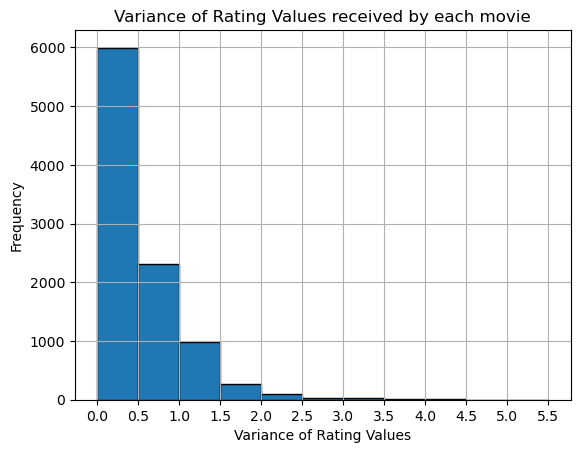

In [ ]:
moviemat = ratings.pivot_table(index="userId",columns="movieId",values="rating")
moviemat.head()
movie_var = np.var(moviemat, axis=0)

plt.hist(movie_var, bins=np.arange(0,max(movie_var)+0.5,0.5),ec="black")
plt.xticks(np.arange(0,max(movie_var)+0.5,0.5))
plt.xlabel("Variance of Rating Values")
plt.ylabel("Frequency")
plt.title("Variance of Rating Values received by each movie")
plt.grid()
plt.savefig("4-Variance of Rating Values received by each movie", dpi=300, bbox_inches="tight")

### <strong>Question 2: Understanding the Pearson Correlation Coefficient</strong>
#### A.
$$\mu_{u}=\frac{\sum_{k\in I_{u}}^{}r_{uk}}{\left|I_{u}\right|}$$
#### B.
$I_{u}\cap I_{v}$ is the set of item indices for which ratings have been specified by both user $u$ and user $v$.<br>
$I_{u}\cap I_{v}=\emptyset$ when items are rated neither by user $u$ nor by user $v$.

### <strong>Question3: Understanding the Prediction function</strong>
#### Explain the reason behind mean-centering the raw ratings $r_{vj} - u_{v}$ in the prediction function.<br>
The Mean-Centering offsets the impact of different users' rating habits on the prediction function. Suppose two users $u$ and $v$ share similar taste but have different rating creteria, say user $u$ is more inclined to give stricter ratings than user $v$, then with Mean-Centering,  ratings are balanced without artificial biases in potential. Otherwise the recommendation system would give improper prediction swayed by different users' rating habits.

### <strong>Question 4</strong><br>
From the result shown below, we observed that in general, both Average RMSE and Average MAE decreases monotically with $k$ increasing from 2 to 100 in step sizes of 2. It suggests that incorporating more users (<em>i.e.</em>, increase $k$) into similariry measurement in k-NN tends to yield better model performance.

100%|██████████| 50/50 [02:47<00:00,  3.36s/it]


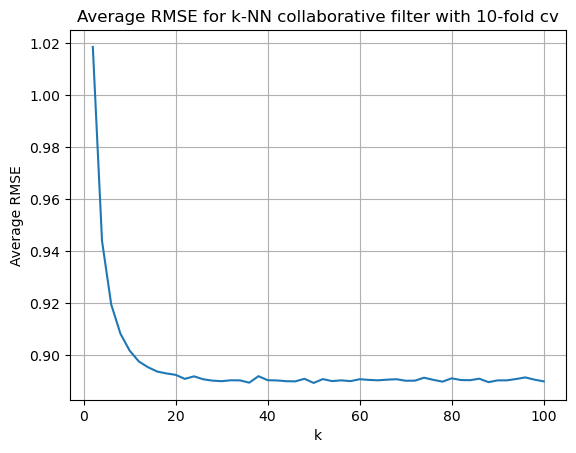

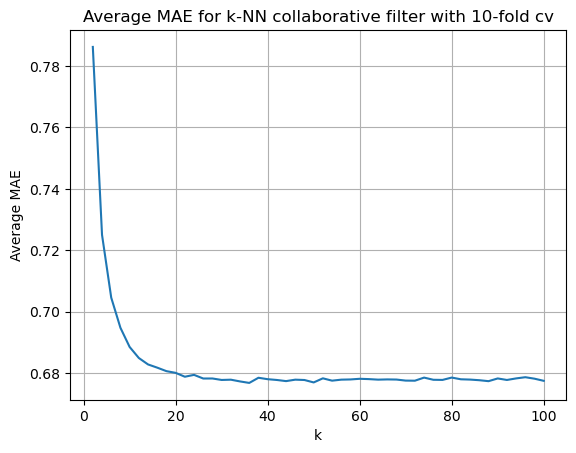

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

k = np.linspace(start=2, stop=100, num=int((100-2)/2 + 1), dtype=int)
avg_RMSE = []
avg_MAE = []
for i in tqdm(k):
    knn = KNNWithMeans(k=i, sim_options={'name': 'pearson', 'user_based': True},verbose=False)
    cv_scores = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_RMSE.append(cv_scores['test_rmse'].mean())
    avg_MAE.append(cv_scores['test_mae'].mean())

plt.figure()
plt.plot(k, avg_RMSE)
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.title("Average RMSE for k-NN collaborative filter with 10-fold cv")
plt.grid()
plt.savefig("5-Average RMSE for k-NN", dpi=300, bbox_inches="tight")

plt.figure()
plt.plot(k, avg_MAE)
plt.xlabel("k")
plt.ylabel("Average MAE")
plt.title("Average MAE for k-NN collaborative filter with 10-fold cv")
plt.grid()
plt.savefig('6-Average MAE for k-NN',dpi=300, bbox_inches="tight")

### <strong>Question 5: find a minimum k, and report the steady state values of average RMSE and average MAE</strong><br>
Assume that "a significant decrease in average RMSE and average MAE" is no less than 0.0005 in their respective values, then as shown in the cell below, we obtain:<br><br>
Minimum $k$ of RMSE is **28**, with minimal average RMSE: **0.8901636872800849**.<br>
Minimum $k$ of MAE is **26**, with minimal average RMSE: **0.6782240440278222**.<br>

In [ ]:
for i in range(len(k)):
    if abs(avg_RMSE[i] - avg_RMSE[i+1]) < 0.0005:
        print(f"minimum k for RMSE: {k[i]}, with minimal average RMSE: {avg_RMSE[i]}")
        knn_opt_k = k[i]
        break

for i in range(len(k)):
    if abs(avg_MAE[i] - avg_MAE[i+1]) < 0.0005:
        print(f"minimum k for MAE: {k[i]}, with minimal average MAE: {avg_MAE[i]}")
        break

minimum k for RMSE: 28, with minimal average RMSE: 0.8901636872800849
minimum k for MAE: 26, with minimal average MAE: 0.6782240440278222


### <strong>Question 6</strong>

#### Plot average RMSE against k and report the minimum average RMSE, within each of the 3 trimmed subsets in the dataset<br>
(1)Minimum Average RMSE for **popular movie** trimming testset is **0.8727191091921649**, and its average RMSE against k is plotted in the cell below. This RMSE is similar to the stable RMSE value of the whole dataset without trimming computed in the previous cell(<em>i.e.</em>, 0.8901636872800849), suggesting that removing unpopular items actually stablize testing performance.<br>
<br>(2)Minimum Average RMSE for **unpopular movie** trimming testset is **1.1124930580891699**, and its average RMSE against k is plotted in the cell below.</br>
<br>(3)Minimum Average RMSE for **high variance movie** trimming testset is **1.4319667712694435**, and its average RMSE against k is plotted in the cell below.</br>
<br> The plots of average RMSE against k for **unpopular** and **high variance** trimming dataset show high fluctuations, which indicates great difficulty in finding neighbors in K-NN due to high sparsity in these datasets.

/var/folders/yh/gkj3y65s6vj2j5kpjjv15gr00000gn/T/ipykernel_2865/891529833.py:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  hvar_movieId = movie_var.index[movie_var.values>=2] & movie_id.index[movie_id.values>=5]
100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


Minimum Average RMSE for popular movie trimming testset is:
 0.8727191091921649


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Minimum Average RMSE for unpopular movie trimming testset is:
 1.1124930580891699


100%|██████████| 50/50 [00:58<00:00,  1.16s/it]

Minimum Average RMSE for high variance movie trimming testset is:
 1.4319667712694435


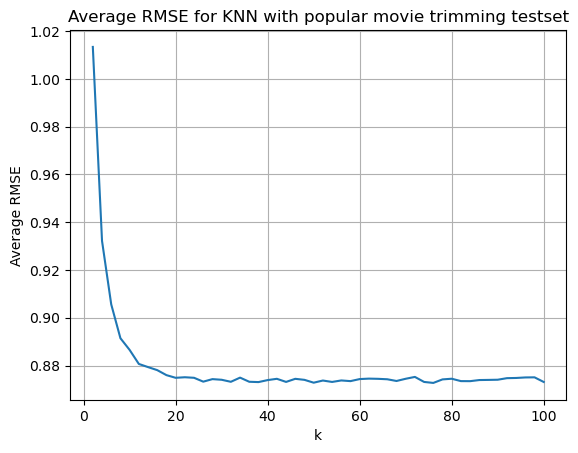

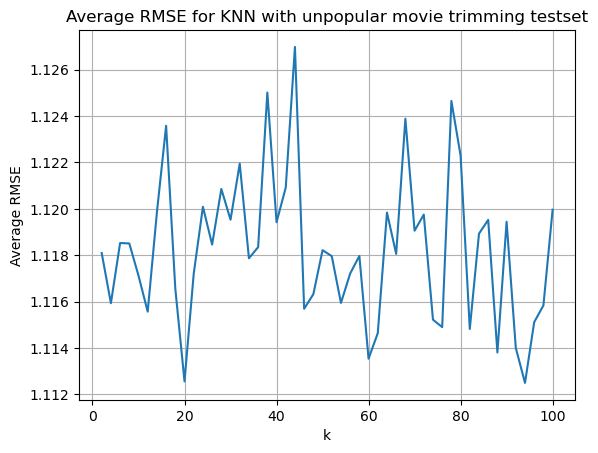

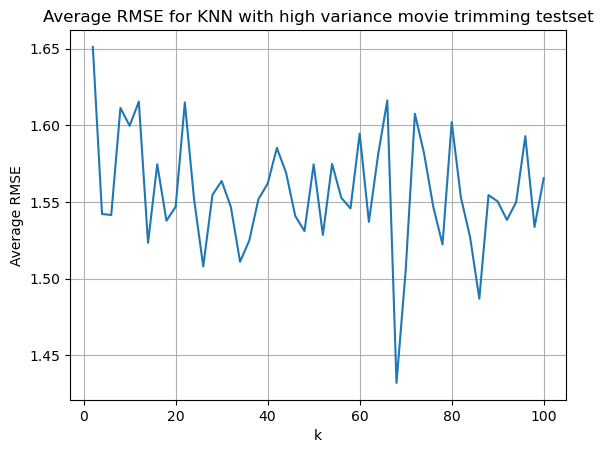

In [ ]:
movie_id = ratings.groupby('movieId')['rating'].count()
pop_movieId = movie_id.index[movie_id.values>2]
unpop_movieId = movie_id.index[movie_id.values<=2]
hvar_movieId = movie_var.index[movie_var.values>=2] & movie_id.index[movie_id.values>=5]

filename = ["popular movie trimming testset",
            "unpopular movie trimming testset",
            "high variance movie trimming testset"]

k = np.linspace(start=2, stop=100, num=int((100-2)/2 + 1), dtype=int)

trimmed_rmse_plot(trimming, k, pop_movieId, filename[0], data)
trimmed_rmse_plot(trimming, k, unpop_movieId, filename[1], data)
trimmed_rmse_plot(trimming, k, hvar_movieId, filename[2], data)

#### Plot the ROC curve<br>
The ROC curves and their respective AUC, for different threshold values in {2.5, 3, 3.5, 4} and 4 trimming options, are reported in the cell below. Here we use the optimal $k=28$ found in Question 5.

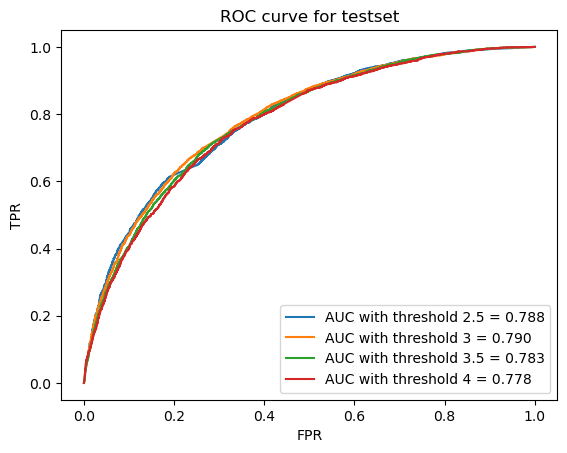

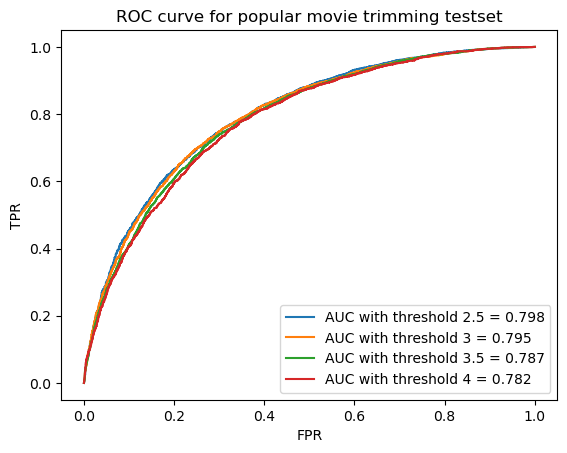

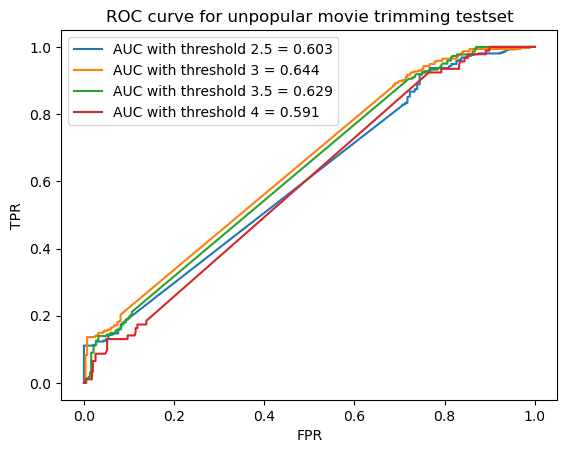

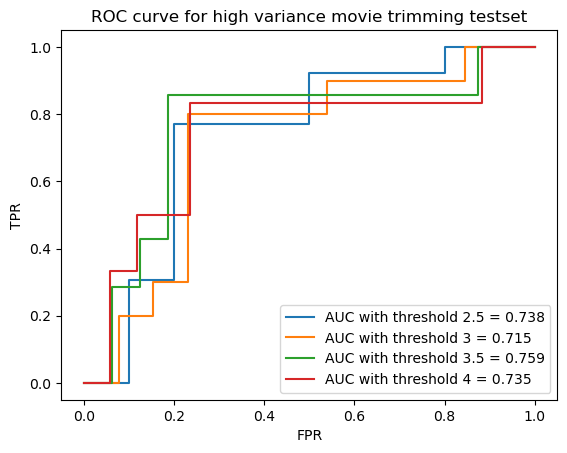

In [ ]:
fname = ['ROC curve for testset','ROC curve for popular movie trimming testset','ROC curve for unpopular movie trimming testset',
            'ROC curve for high variance movie trimming testset']
trainset, testset = train_test_split(data, test_size=0.1,random_state=0)
knn = KNNWithMeans(k=28, sim_options={'name': 'pearson', 'user_based': True},verbose=False)
knn.fit(trainset)

plot_roc_curve(testset, fname[0], knn)
plot_roc_curve(trimming(testset, pop_movieId), fname[1], knn)
plot_roc_curve(trimming(testset, unpop_movieId), fname[2], knn)
plot_roc_curve(trimming(testset, hvar_movieId), fname[3], knn)

### <strong>Question 7</strong><br>
The the optimization problem given by equation 5 is convex if the Hessian Matrix associated is positive semi-definite. To start with simplicity, let us assume that $m,n,k = 1$ and $W_{11} = 1$. Therefore, equation (5) $$\underset{U, V}{\operatorname{minimize}} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{i j}\left(r_{i j}-\left(U V^{T}\right)_{i j}\right)^{2}$$ is equivalent to minimize $$L(U, V)=\frac{1}{2}(R-U V)^{2}$$ where the constant $\frac{1}{2}$ is for the convenience of calculating derivative. The Hessian Matrix <em>w.r.t.</em> $U$, $V$ is $$\nabla^{2} L(U, V)=\left[\begin{array}{cc}
\frac{\partial^{2} L}{\partial U^{2}} & \frac{\partial^{2} L}{\partial U \partial V} \\
\frac{\partial^{2} L}{\partial V \partial U} & \frac{\partial^{2} L}{\partial V^{2}}
\end{array}\right]=\left[\begin{array}{cc}
V^{2} & -R+2 U V \\
-R+2 U V & U^{2}
\end{array}\right]$$ with determinant $$\left|\nabla^{2} L(U, V)\right|=-(R-U V)(R-3 U V),$$ which is not always non-negative. Therefore, the simplified optimization problem is NOT positive semi-definite and thus NOT convex. It can be shown that for general $m,n,k$, the obejective is also NOT convex. When $U$ is fixed, the objective is $$L(V)=\frac{1}{2} \sum_{j=1}^{n}\left(r_{j}-U V_{j}\right)^{\top} W_{j}\left(r_{j}-U V_{j}\right),$$ where
$\begin{cases}
 r_{j}=[r_{1j}, r_{2j}, ..., r_{mj}]^{\top}\\
 V_{j}=[V_{1j}, V_{2j}, ..., V_{mj}]^{\top}\\
 W_{j}=diag(W_{1j}, W_{2j}, ..., W_{mj})\\
\end{cases}$. This is a weighted least-square problem, and the optimal $V$ is $$V_{j}^{opt}=\left(U^{\top} W_{j} U\right)^{-1} U^{\top} W_{j} r_{j}, \quad j=1, 2, \cdots, n.$$

### <strong>Question 8: Designing the NMF Collaborative Filter</strong>

#### A.<br>
The average RMSE and average MAE, obtained by averaging the RMSE and MAE across all 10 folds, for each $k$ going from 2 to 50 in step sizes of 2 are plotted in the cell below.

100%|██████████| 25/25 [04:38<00:00, 11.15s/it]


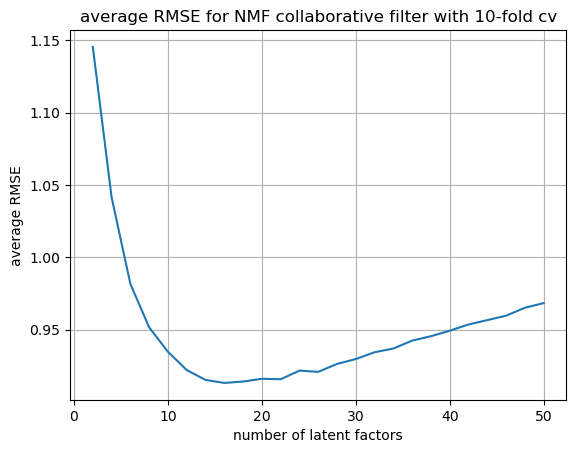

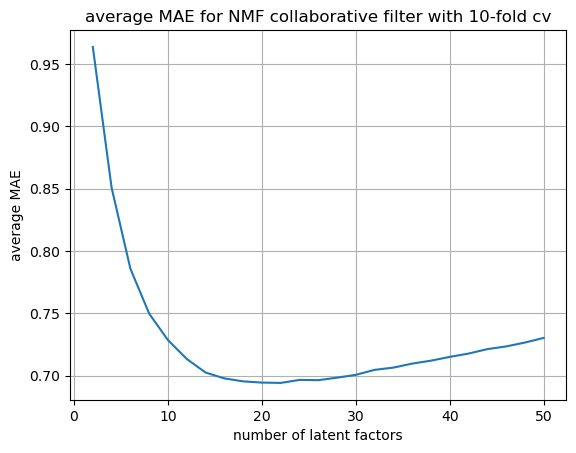

In [ ]:
k = np.linspace(start=2, stop=50, num=int((50-2)/2 + 1), dtype=int)
avg_RMSE = []
avg_MAE = []
for i in tqdm(k):
    nmf_model = NMF(n_factors=i)
    cv_scores = cross_validate(nmf_model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_RMSE.append(cv_scores['test_rmse'].mean())
    avg_MAE.append(cv_scores['test_mae'].mean())

plt.figure()
plt.plot(k, avg_RMSE)
plt.title("average RMSE for NMF collaborative filter with 10-fold cv")
plt.xlabel('number of latent factors')
plt.ylabel('average RMSE')
plt.grid()
plt.savefig('wh1-average RMSE for NMF',dpi=300, bbox_inches='tight')

plt.figure()
plt.plot(k, avg_MAE)
plt.title("average MAE for NMF collaborative filter with 10-fold cv")
plt.xlabel('number of latent factors')
plt.ylabel('average MAE')
plt.grid()
plt.savefig('wh2-average MAE for NMF',dpi=300, bbox_inches='tight')


#### B.<br>
The optimal number of latent factors is **18**, with the minimum average RMSE **0.9142261439883524** and the minimum average MAE **0.6953037284113109**, as shown in the cell below. <br>
<br>The number of movie genres is 19, including "no genres listed".<br>
<br>The optimal number of latent factors is very close to the number of movie genres, indicating that the latent factors offer a well-interpretable explanation for the number of movie genres.

In [ ]:
combined_score = np.array(avg_RMSE) + np.array(avg_MAE)
best_index = np.argmin(combined_score)
print(f"Optimal number of latent factor:\n{k[best_index]}, with \nRMES\n{avg_RMSE[best_index]}, and\nMAE\n{avg_MAE[best_index]}")

genres = pd.read_csv('movies.csv', delimiter=',')
genres_str = ''.join(genres['genres'])
genres_list = genres_str.split("|")
genres_str = ''.join(genres_list)
genres_list = re.findall('[A-Z][a-z]+(?:\-[A-Z])?[a-z]+', genres_str)

print("\nNumber of movie genres:", len(set(genres_list))+1) # including (no genres listed)

Optimal number of latent factor:
18, with 
RMES
0.9142261439883524, and
MAE
0.6953037284113109

Number of movie genres: 19


#### C.<br>
As shown in the cell below, <br>
<br>(1) The minimum average RMSE for popular movie trimming testset is: **0.873133177915353**
<br>(2) The minimum average RMSE for unpopular movie trimming testset is: **1.109736183858267**
<br>(3) The minimum average RMSE for high variance movie trimming testset is: **1.4976529889686407**<br>
<br>Plots on average RMSE against $k$, for the three trimmed datasets, follow behind.


100%|██████████| 25/25 [01:16<00:00,  3.04s/it]


Minimum Average RMSE for popular movie trimming testset is:
 0.873133177915353


100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


Minimum Average RMSE for unpopular movie trimming testset is:
 1.109736183858267


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]

Minimum Average RMSE for high variance movie trimming testset is:
 1.4976529889686407


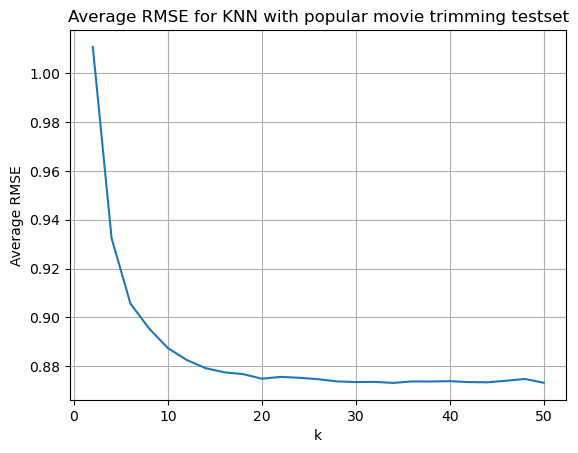

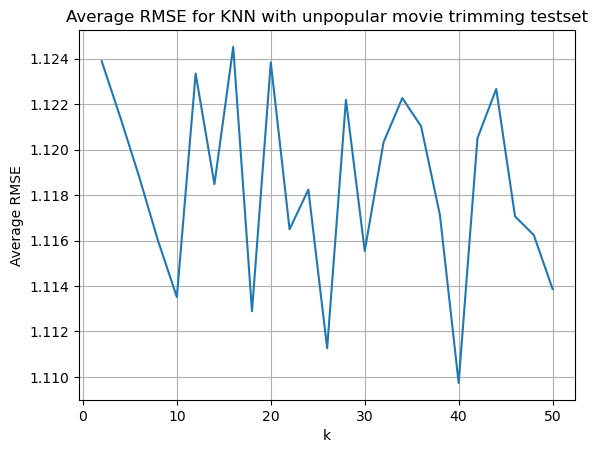

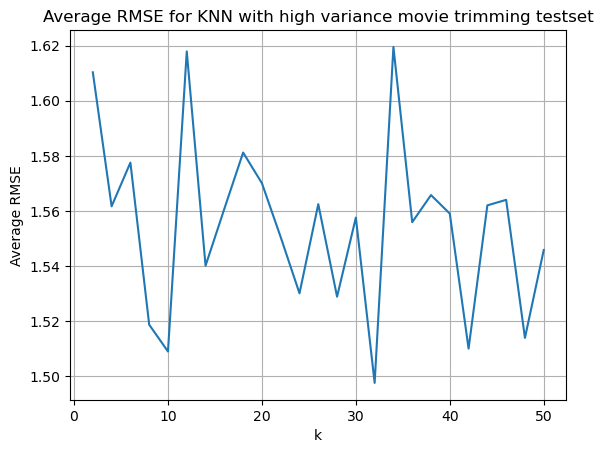

In [ ]:
filename = ["popular movie trimming testset",
            "unpopular movie trimming testset",
            "high variance movie trimming testset"]

k = np.linspace(start=2, stop=50, num=int((50-2)/2 + 1), dtype=int)

trimmed_rmse_plot(trimming, k, pop_movieId, filename[0], data, save_flag=False)
trimmed_rmse_plot(trimming, k, unpop_movieId, filename[1], data, save_flag=False)
trimmed_rmse_plot(trimming, k, hvar_movieId, filename[2], data, save_flag=False)

#### D. Plot ROC curves and report AUC's <br>
The ROC curves and their respective AUC, for different threshold values in {2.5, 3, 3.5, 4} and 4 trimming options, are reported in the cell below. Here we use $k=18$ found in (A).

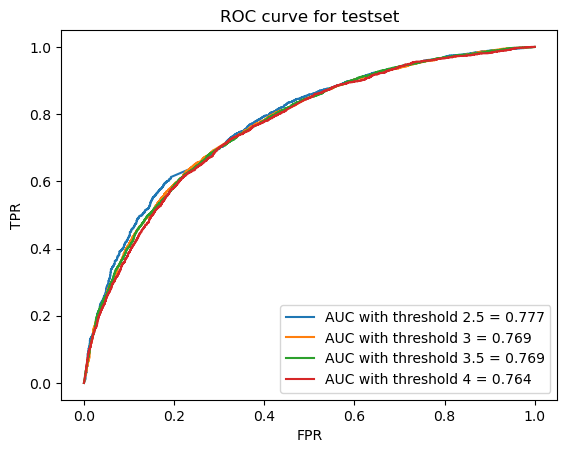

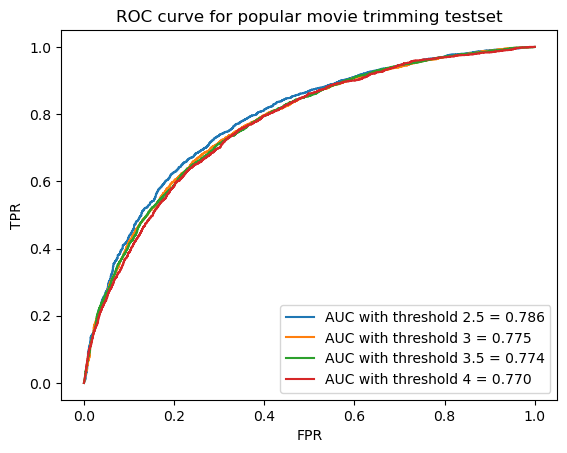

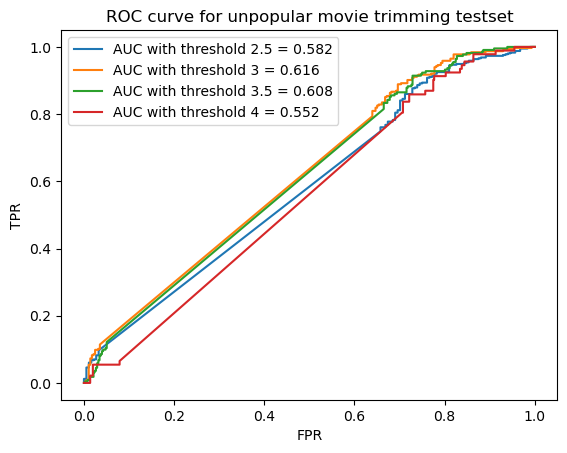

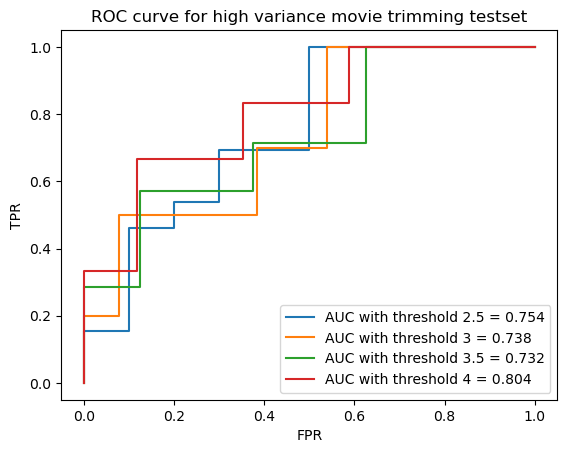

In [ ]:
fname = ["ROC curve for testset",
         "ROC curve for popular movie trimming testset",
         "ROC curve for unpopular movie trimming testset",
         "ROC curve for high variance movie trimming testset"]

trainset, testset = train_test_split(data, test_size=0.1,random_state=0)
nmf_model = NMF(n_factors=18)
nmf_model.fit(trainset)

plot_roc_curve(testset, fname[0], nmf_model, save_flag=False)
plot_roc_curve(trimming(testset, pop_movieId), fname[1], nmf_model, save_flag=False)
plot_roc_curve(trimming(testset, unpop_movieId), fname[2], nmf_model, save_flag=False)
plot_roc_curve(trimming(testset, hvar_movieId), fname[3], nmf_model, save_flag=False)

### <strong>Question 9: Interpreting the NMF model</strong><br>
We summaries information regaring Top-10 items for column 0-19 in the cell below.<br>
<p>(1) Do the top 10 movies belong to a particular or a small collection of genre?</p>
<p>Yes. As we observed from the result of "top-10 items for column 1", most of items belongs to "Drama" and "Comedy". Similarly, in the result of "top-10 items for column 18", most of items belongs to "Drama" and "Romance". It indicates that the top 10 movies belong to a particular or a small collection of genre.</p>
<p>(2) Is there a connection between the latent factors and the movie genres?</p>
<p>Yes. We have observed in (1) that for each column(latent factor), the top-10 movies belong to a particular collection of genre. And for different latent factors the small collections differs. So there should be a connection between latent factors and the movie genres. </p>


In [ ]:
datareader = csv.reader(open('movies.csv', 'r'), delimiter=',')

movie_genres = {}
for row in datareader:
    movie_genres[row[0]] = row[2]

all_genres = []
for id in movie_genres:
    all_genres += movie_genres[id].split('|')

trainset = data.build_full_trainset()
nmf_model = NMF(n_factors=20)
nmf_model.fit(trainset)

for i in range(20):
    V = nmf_model.qi.copy()
    movie_raw_ids = [trainset.to_raw_iid(iiid) for iiid in np.argsort(V[:, i])[-10:]]
    genre_raw, genre = [], []
    for mid in movie_raw_ids:
        genre_raw.append(movie_genres[str(mid)])
        genre += movie_genres[str(mid)].split('|')
    print("\n******************************************************")
    print(f"Top-10 items for column {i}:\n")
    print("(Movie index || Genre associated):\n")
    for item in zip(movie_raw_ids, genre_raw):
        print(item)
    print(Counter(genre))


******************************************************
Top-10 items for column 0:

(Movie index || Genre associated):

(79185, 'Action|Comedy|Romance')
(77866, 'Action|Adventure|Drama|Romance|War')
(879, 'Horror|Thriller')
(1432, 'Action|Comedy|Crime|Drama|Thriller')
(43928, 'Action|Fantasy|Sci-Fi|Thriller')
(2534, 'Action')
(4915, 'Action|Adventure|Fantasy')
(102, 'Comedy')
(1415, 'Crime|Drama|Romance')
(8138, 'Horror|Sci-Fi')
Counter({'Action': 6, 'Comedy': 3, 'Romance': 3, 'Drama': 3, 'Thriller': 3, 'Adventure': 2, 'Horror': 2, 'Crime': 2, 'Fantasy': 2, 'Sci-Fi': 2, 'War': 1})

******************************************************
Top-10 items for column 1:

(Movie index || Genre associated):

(1373, 'Action|Sci-Fi')
(125, 'Comedy')
(8951, 'Drama')
(25850, 'Comedy|Drama|Romance')
(2349, 'Comedy|Thriller')
(1594, 'Comedy|Drama')
(86320, 'Drama|Sci-Fi')
(650, 'Drama')
(151315, 'Action|Comedy')
(112804, 'Drama|Sci-Fi')
Counter({'Drama': 6, 'Comedy': 5, 'Sci-Fi': 3, 'Action': 2, 'Roma

### <strong>Question 10: Designing the MF Collaborative Filter</strong>

#### A.<br>
The average RMSE and average MAE, obtained by averaging the RMSE and MAE across all 10 folds, for each k going from 2 to 50 in step sizes of 2, are plotted in the cell below.

100%|██████████| 25/25 [03:14<00:00,  7.78s/it]


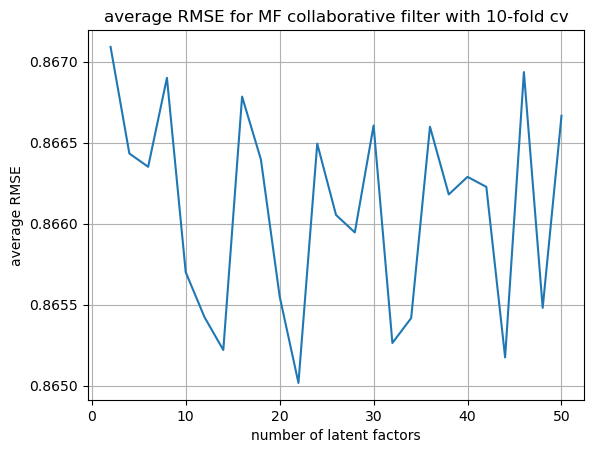

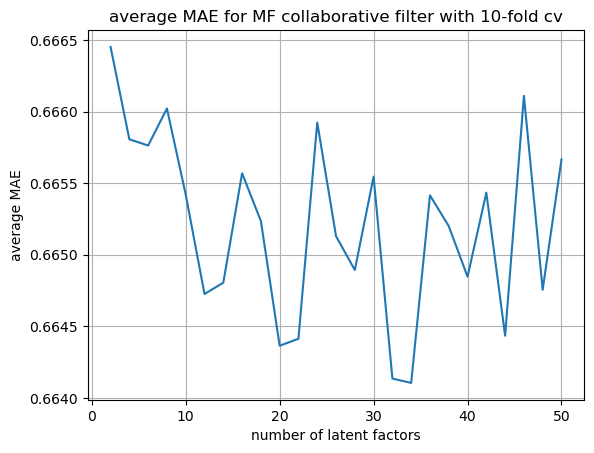

In [ ]:
k = np.linspace(start=2, stop=50, num=int((50-2)/2 + 1), dtype=int)

avg_RMSE = []
avg_MAE = []

for i in tqdm(k):
    mf_model = SVD(n_factors=i)
    cv_scores = cross_validate(mf_model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_RMSE.append(cv_scores['test_rmse'].mean())
    avg_MAE.append(cv_scores['test_mae'].mean())

plt.figure()
plt.plot(k, avg_RMSE)
plt.title("average RMSE for MF collaborative filter with 10-fold cv")
plt.xlabel('number of latent factors')
plt.ylabel('average RMSE')
plt.grid()
plt.savefig('wh3-average RMSE for MF',dpi=300, bbox_inches='tight')

plt.figure()
plt.plot(k, avg_MAE)
plt.title("average MAE for MF collaborative filter with 10-fold cv")
plt.xlabel('number of latent factors')
plt.ylabel('average MAE')
plt.grid()
plt.savefig('wh4-average MAE for MF',dpi=300, bbox_inches='tight')

#### B.<br>
As shown in the cell below, the optimal number of latent factors is $k=32$, considering the mean of "RMSE average" and "MAE average". <br>
<br> The number of movie genres is 19 as calculated before.<br>
<br> The optimal number of latent factors is greater than the number of movie genres.

In [ ]:
combined_score = np.array(avg_RMSE) + np.array(avg_MAE)
best_index = np.argmin(combined_score)

print(f"Optimal number of latent factor:\n{k[best_index]}, with \nRMES\n{avg_RMSE[best_index]}, and\nMAE\n{avg_MAE[best_index]}")

print("\nNumber of movie genres:", len(set(genres_list))+1) # including (no genres listed)

Optimal number of latent factor:
32, with 
RMES
0.8652625154361282, and
MAE
0.6641358001165429

Number of movie genres: 19


#### C.

##### (1), (2)<br>
<br> The cell blow plots the RMSE against $k$ for each of popular, unpopular and high variance subsets. </br>
<br>(1) The minimum average RMSE for **popular** movie trimming testset is **0.8574272417864057** </br>
<br>(2) The minimum average RMSE for **unpopular** movie trimming testset is **0.9722373174757906** </br>
<br>(3) The minimum average RMSE for **high variance** movie trimming testset is **1.4299948435149943** </br>

100%|██████████| 25/25 [03:01<00:00,  7.27s/it]


The minimum average RMSE for popular movie trimming testset is: 0.8574272417864057


100%|██████████| 25/25 [02:52<00:00,  6.90s/it]


The minimum average RMSE for unpopular movie trimming testset is: 0.9722373174757906


100%|██████████| 25/25 [02:46<00:00,  6.65s/it]

The minimum average RMSE for high variance movie trimming testset is: 1.4299948435149943


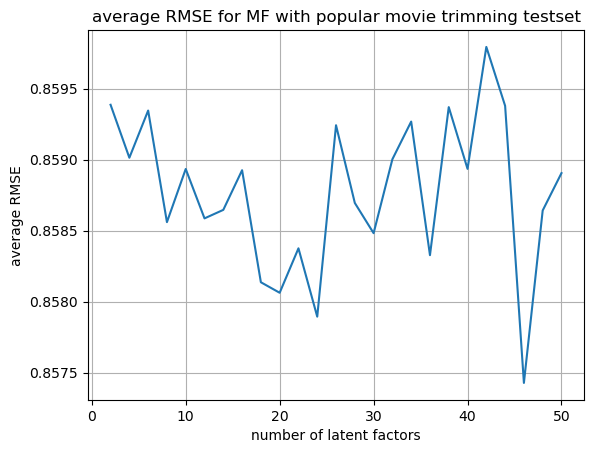

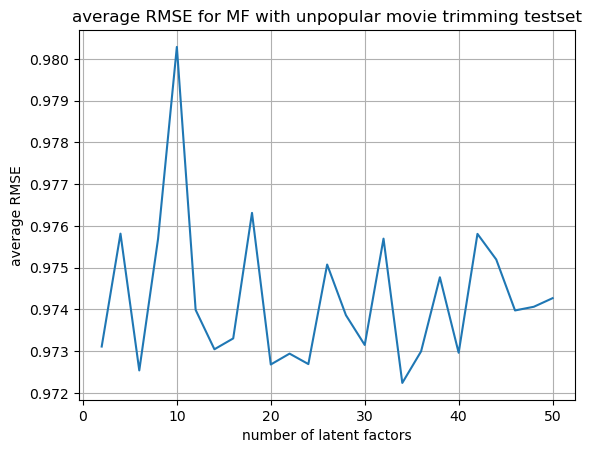

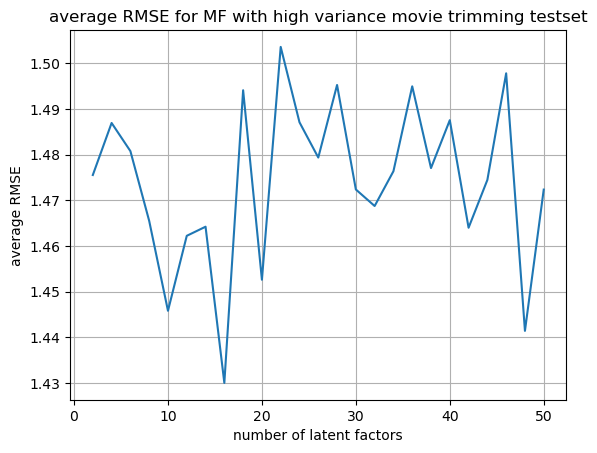

In [ ]:
def trimmed_rmse_plot_Q10(trimming, k, domain, filename, data, save_flag=False):
    cv = KFold(n_splits=10)
    avg_rmse = []
    for i in tqdm(k):
        rmse = []
        for trainset, testset in cv.split(data):
            trimmed_testset = trimming(testset, domain)
            mf_model = SVD(n_factors=i)
            mf_model.fit(trainset)
            predictions = mf_model.test(trimmed_testset)
            rmse.append(accuracy.rmse(predictions, verbose=False))
        avg_rmse.append(np.mean(rmse))
    plt.figure()
    plt.plot(k, avg_rmse)
    plt.title("average RMSE for MF with "+filename)
    plt.xlabel('number of latent factors')
    plt.ylabel('average RMSE')
    plt.grid()
    if save_flag:
        plt.savefig(filename,dpi=300, bbox_inches='tight')
    print("The minimum average RMSE for "+ filename + " is:", min(avg_rmse))


filename = ['popular movie trimming testset',
            'unpopular movie trimming testset',
            'high variance movie trimming testset']

k = np.linspace(start=2, stop=50, num=int((50-2)/2 + 1), dtype=int)

trimmed_rmse_plot_Q10(trimming, k, pop_movieId, filename[0], data)
trimmed_rmse_plot_Q10(trimming, k, unpop_movieId, filename[1], data)
trimmed_rmse_plot_Q10(trimming, k, hvar_movieId, filename[2], data)

#### (3) <br>
The ROC curves and the AUC associated are plotted and calculated in the cell below.

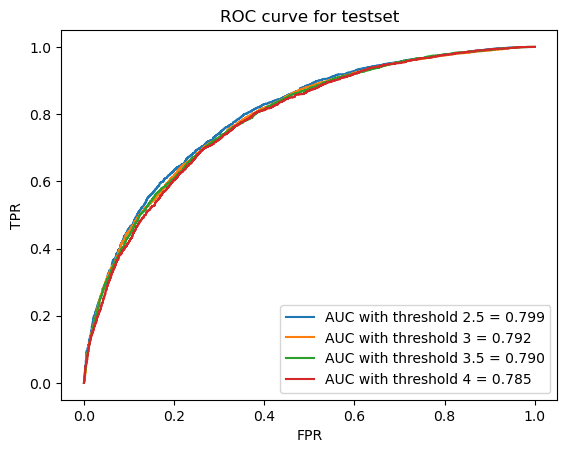

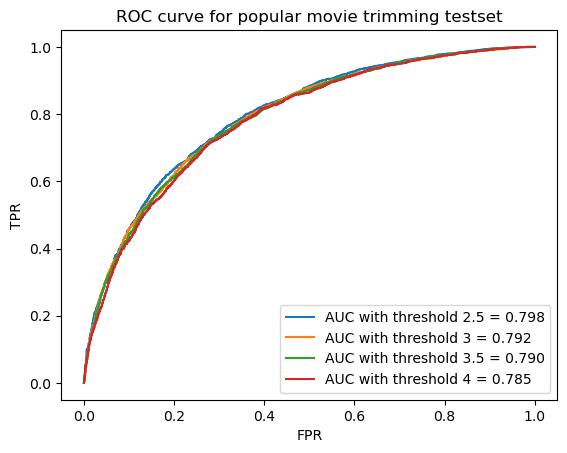

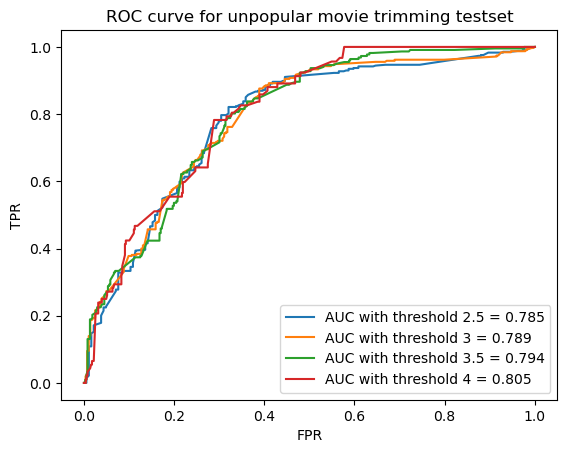

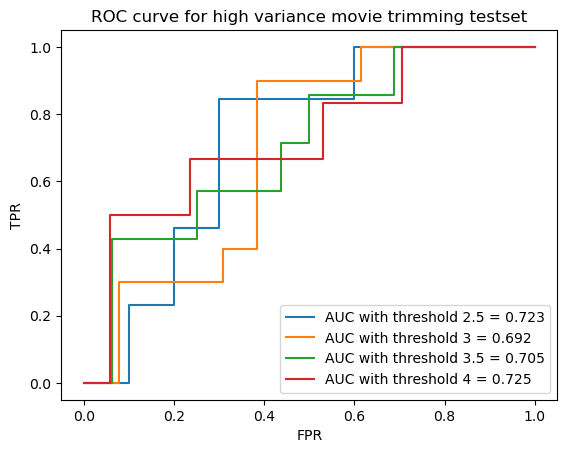

In [ ]:
fname = ['ROC curve for testset',
         'ROC curve for popular movie trimming testset',
         'ROC curve for unpopular movie trimming testset',
         'ROC curve for high variance movie trimming testset']

trainset, testset = train_test_split(data, test_size=0.1,random_state=0)
mf_model = SVD(n_factors=18)
mf_model.fit(trainset)

plot_roc_curve(testset, fname[0], mf_model)
plot_roc_curve(trimming(testset, pop_movieId), fname[1], mf_model)
plot_roc_curve(trimming(testset, unpop_movieId), fname[2], mf_model)
plot_roc_curve(trimming(testset, hvar_movieId), fname[3], mf_model)

### <strong>Question 11: Design a Naive Collaborative Filter</strong>

#### (1) <br>
The Average RMSE for Naive Collaborative Filtering is **1.0425**.

In [ ]:
class Naive(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.the_mean = np.mean([r for (_, _, r) in self.trainset.all_ratings()])
        return self

    def estimate(self, u, i):
        return self.the_mean

naive = Naive()
cv = cross_validate(naive, data, cv=KFold(n_splits=10, random_state=42))
print('Average RMSE for Naive Collaborative Filtering: %.4f' %np.mean(cv['test_rmse']))

Average RMSE for Naive Collaborative Filtering: 1.0425


#### (2) <br>
<br>(1) Average RMSE after **popular** movie trimming for Naive Collaborative Filtering is **1.0357**.</br>
<br>(2) Average RMSE after **unpopular** movie trimming for Naive Collaborative Filtering is **1.1430**.</br>
<br>(3) Average RMSE after **high variance** movie trimming for Naive Collaborative Filtering is **1.7075**.</br>

In [ ]:
naive_rmse_pop_trim = []

for trainset,testset in KFold(n_splits=10, random_state=42).split(data):
    naive.fit(trainset)
    testset_trimmed = trimming(testset, pop_movieId)
    pred = naive.test(testset_trimmed)
    naive_rmse_pop_trim.append(accuracy.rmse(pred, verbose=False))

print('Average RMSE after popular movie trimming for Naive Collaborative Filtering: %.4f' %np.mean(naive_rmse_pop_trim))

Average RMSE after popular movie trimming for Naive Collaborative Filtering: 1.0357


In [ ]:
naive_rmse_unpop_trim = []

for trainset,testset in KFold(n_splits=10, random_state=42).split(data):
    naive.fit(trainset)
    testset_trimmed = trimming(testset, unpop_movieId)
    pred = naive.test(testset_trimmed)
    naive_rmse_unpop_trim.append(accuracy.rmse(pred, verbose=False))

print('Average RMSE after unpopular movie trimming for Naive Collaborative Filtering: %.4f' %np.mean(naive_rmse_unpop_trim))

Average RMSE after unpopular movie trimming for Naive Collaborative Filtering: 1.1430


In [ ]:
naive_rmse_hvar_trim = []

for trainset,testset in KFold(n_splits=10, random_state=42).split(data):
    naive.fit(trainset)
    testset_trimmed = trimming(testset, hvar_movieId)
    pred = naive.test(testset_trimmed)
    naive_rmse_hvar_trim.append(accuracy.rmse(pred, verbose=False))

print('Average RMSE after high variance movie trimming for Naive Collaborative Filtering: %.4f' %np.mean(naive_rmse_hvar_trim))

Average RMSE after high variance movie trimming for Naive Collaborative Filtering: 1.7075


### <strong>Question 12</strong><br>
The best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters are plotted in the cell below.

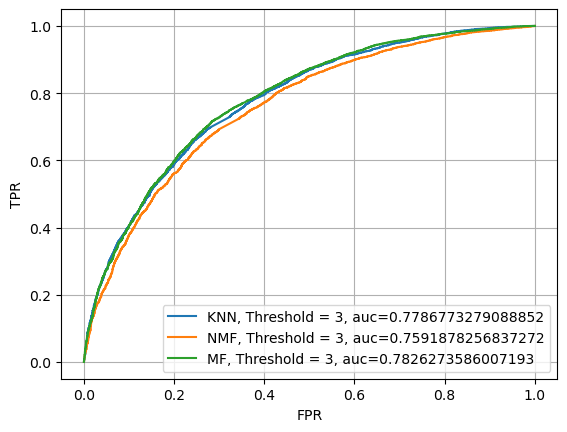

In [ ]:
threshold = 3

model1 = KNNWithMeans(k=28, sim_options={'name': 'pearson', 'user_based': True},verbose=False)
model2 = NMF(n_factors=18)
model3 = SVD(n_factors=32)

model1.fit(trainset)
pred1 = model1.test(testset)
model2.fit(trainset)
pred2 = model2.test(testset)
model3.fit(trainset)
pred3 = model3.test(testset)

y1 = [1 if p[2] > threshold else 0 for p in pred1]
scores1 = [p[3] for p in pred1]
fpr1, tpr1, _ = roc_curve(y1, scores1)
auc1 = roc_auc_score(y1,scores1)
plt.plot(fpr1,tpr1,label="KNN, Threshold = 3, auc="+str(auc1))

y2 = [1 if p[2] > threshold else 0 for p in pred2]
scores2 = [p[3] for p in pred2]
fpr2, tpr2, _ = roc_curve(y2, scores2)
auc2 = roc_auc_score(y2,scores2)
plt.plot(fpr2,tpr2,label="NMF, Threshold = 3, auc="+str(auc2))

y3 = [1 if p[2] > threshold else 0 for p in pred3]
scores3 = [p[3] for p in pred3]
fpr3, tpr3, _ = roc_curve(y3, scores3)
auc3 = roc_auc_score(y3,scores3)
plt.plot(fpr3,tpr3,label="MF, Threshold = 3, auc="+str(auc3))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()

# Ranking (Question 13 - Question 16)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd

# Load the dataset for one fold
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    X_valid, y_valid, qid_valid = load_svmlight_file(str(data_path + 'vali.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    # counts of the unique values
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    _, group_valid = np.unique(qid_valid, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
'''
def get_feature_importance(model, importance_type='gain'):
     return model.feature_importance(importance_type=importance_type)
'''

def get_feature_importance(model, reduced_indices=None, importance_type='gain'):

    if reduced_indices:
      feature_numbers = reduced_indices
    else:
      feature_numbers = model.feature_name()

    importance_df = (
        pd.DataFrame({
            'feature_name': feature_numbers,
            'importance_gain': model.feature_importance(importance_type='gain'),
            'importance_split': model.feature_importance(importance_type='split'),
        })
        .sort_values('importance_gain', ascending=False)
        .reset_index(drop=True)
    )
    return importance_df



## QUESTION 13: Data Understanding and Preprocessing


* Loading and pre-processing Web10k data.
* Print out the number of unique queries in total and show distribution of relevance labels



In [ ]:
# Loading and pre-processing Web10k data.
fold = 1
data_path = '/content/drive/MyDrive/MSLR-WEB10K'
X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid = load_one_fold(data_path + '/Fold'+str(fold)+'/')
unique_qids = np.unique(np.concatenate((qid_train, qid_test, qid_valid)))
num = len(unique_qids)
print(f"The number of unique queries: {num}")

The number of unique queries: 10000


Distribution of relevance labels:
Label 0: 624263
Label 1: 386280
Label 2: 159451
Label 3: 21317
Label 4: 8881


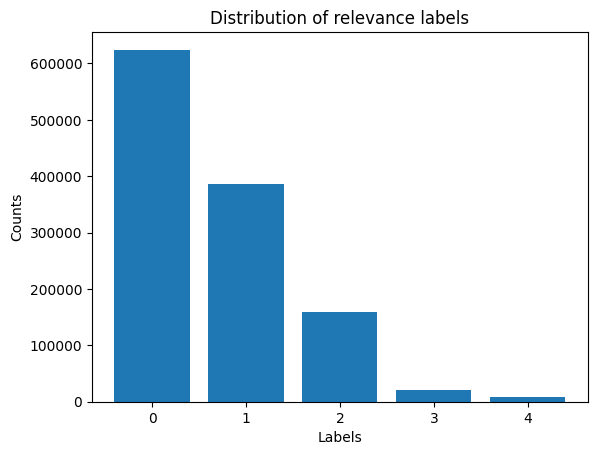

In [ ]:
import matplotlib.pyplot as plt

# show distribution of relevance labels
labels_all = np.concatenate((y_train, y_test, y_valid))
labels, counts = np.unique(labels_all, return_counts=True)
label_distribution = {label: counts[i] for i, label in enumerate(labels)}

print(f"Distribution of relevance labels:")
for label, count in label_distribution.items():
    print(f"Label {int(label)}: {count}")

# plot the distribution
plt.bar(label_distribution.keys(), label_distribution.values())
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Distribution of relevance labels")
plt.show()

### QUESTION 14: LightGBM Model Training
For each of the five provided folds, train a LightGBM model using the `lambdarank` objective. After training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and nDCG@10.

Answer:

| nDCG | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|  -------- | -------- | -------- | -------- | -------- | -------- |
| nDCG@3 | 0.453 | 0.455 | 0.4425 | 0.4514 | 0.4607 |
| nDCG@5 | 0.460 | 0.460 | 0.4509 | 0.4588 | 0.4649 |
| nDCG@10 | 0.478  | 0.478 | 0.4692 | 0.4791 | 0.4842 |


In [ ]:
import lightgbm as lgb

# Train the model and evaluate it's performance
def train_and_evaluate_one_fold_with_validation(data_path, X_train, y_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid):

  train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
  valid_data = lgb.Dataset(X_valid, label=y_valid, group=group_valid, free_raw_data=False)
  test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False, reference=train_data)

  params = {
      'objective': 'lambdarank',
      'metric': 'ndcg',
      'ndcg_eval_at': [3, 5, 10], #NDCG 3, 5,10
      'learning_rate': 0.08,
      'num_leaves': 31,
      'verbose': -1
  }
  num_boost_round = 100
  lgb.cv(params, train_data, num_boost_round, nfold=5)
  gbm = lgb.train(params, train_data, num_boost_round, valid_sets=[valid_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

  print('\nModel performance on the test set (nDCG@3, nDCG@5, nDCG@10):')
  for k in [3, 5, 10]:
    ndcg_scores = compute_ndcg_all(gbm, X_test, y_test, qid_test, k)
    print(f'k = {k}, testing ndcg score: {ndcg_scores}')

  return gbm



============= Fold1 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's ndcg@3: 0.479915	valid_0's ndcg@5: 0.485941	valid_0's ndcg@10: 0.503136

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.45313599027464324
k = 5, testing ndcg score: 0.45973616412747803
k = 10, testing ndcg score: 0.4783812804206869
Top 5 feature importance in Fold1:
  feature_name  importance_gain  importance_split
0   Column_133     30242.388412                74
1    Column_54      5674.208008                27
2     Column_7      5238.383710                19
3   Column_107      4611.084961               109
4   Column_129      4403.657952               144



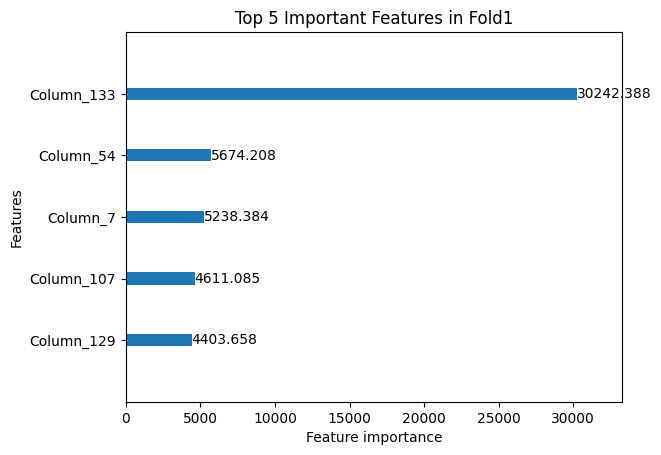


============= Fold2 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@3: 0.468869	valid_0's ndcg@5: 0.47792	valid_0's ndcg@10: 0.498843

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.45495185702465724
k = 5, testing ndcg score: 0.4600554063977864
k = 10, testing ndcg score: 0.4779681003236375
Top 5 feature importance in Fold2:
  feature_name  importance_gain  importance_split
0   Column_133     30371.241097                90
1     Column_7      6069.141505                16
2    Column_54      6049.697562                37
3   Column_129      5254.941437               155
4   Column_107      4999.568038               127



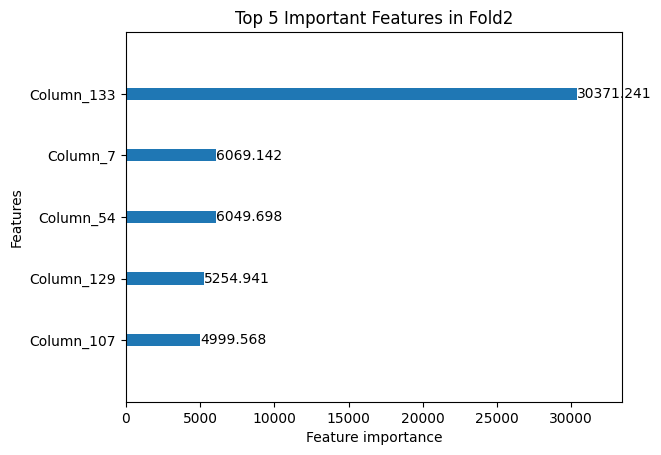


============= Fold3 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's ndcg@3: 0.475575	valid_0's ndcg@5: 0.476535	valid_0's ndcg@10: 0.492221

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.4442475346809804
k = 5, testing ndcg score: 0.451608614869005
k = 10, testing ndcg score: 0.4709070278813585
Top 5 feature importance in Fold3:
  feature_name  importance_gain  importance_split
0   Column_133     29702.651701                64
1    Column_54      6193.638510                25
2   Column_107      5434.690027                98
3     Column_7      4895.245243                11
4   Column_129      4522.065771               107



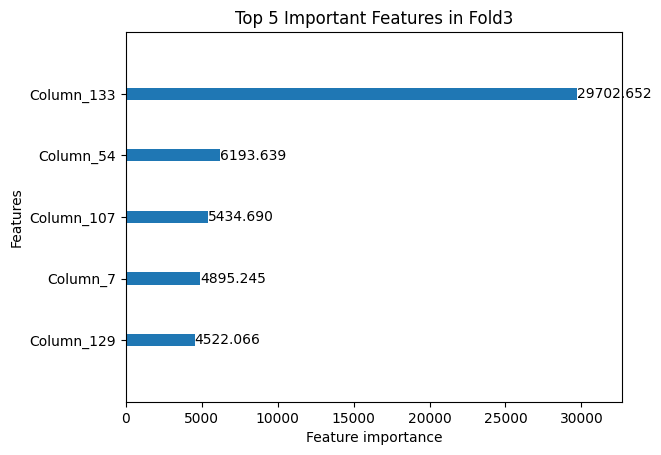


============= Fold4 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@3: 0.461382	valid_0's ndcg@5: 0.465915	valid_0's ndcg@10: 0.486763

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.45675938695251483
k = 5, testing ndcg score: 0.46291603373215495
k = 10, testing ndcg score: 0.48225998733230846
Top 5 feature importance in Fold4:
  feature_name  importance_gain  importance_split
0   Column_133     30445.430473                66
1     Column_7      5748.013741                16
2    Column_54      4672.611840                19
3   Column_107      3871.183474                96
4   Column_129      3805.228875               120



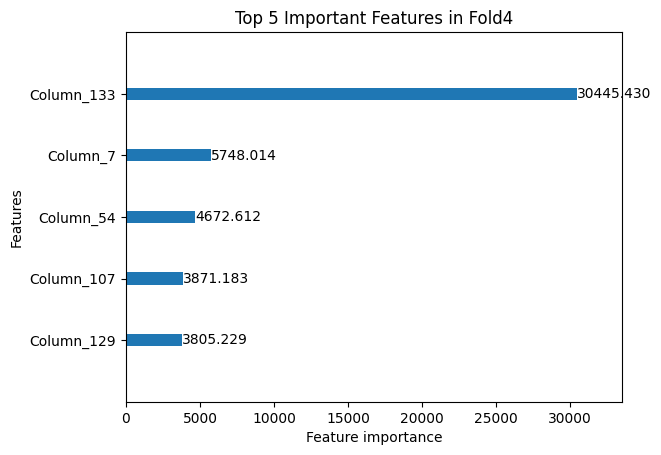


============= Fold5 =============
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's ndcg@3: 0.477856	valid_0's ndcg@5: 0.48436	valid_0's ndcg@10: 0.502242

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.46704953123876863
k = 5, testing ndcg score: 0.4727884528516246
k = 10, testing ndcg score: 0.48988239711777926
Top 5 feature importance in Fold5:
  feature_name  importance_gain  importance_split
0   Column_133     30199.607009                84
1     Column_7      7131.579422                13
2    Column_54      4583.729059                32
3   Column_129      3967.056933               148
4   Column_107      3959.373402               102



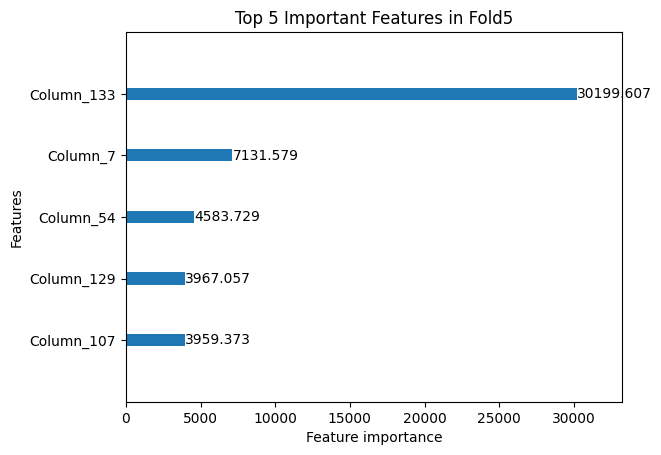

In [ ]:
def plot_feature_importance(gbm, fold):
  feature_importance = get_feature_importance(gbm)
  print(f'Top 5 feature importance in Fold{fold}:\n{feature_importance.head(5)}\n')
  lgb.plot_importance(gbm, importance_type='gain', max_num_features=5, title=f'Top 5 Important Features in Fold{fold}', grid=False)
  plt.show()

for fold in range(1, 6):
  print(f'\n============= Fold{fold} =============')
  X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid = load_one_fold(data_path + '/Fold'+str(fold)+'/')
  GBM = train_and_evaluate_one_fold_with_validation(data_path, X_train, y_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid)
  plot_feature_importance(GBM, fold)

### QUESTION 15: Result Analysis and Interpretation

For each of the five provided folds, list top 5 most important features of the model based on the importance score. Use importance_type='gain'.

Answer:

| No. | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|  -------- | -------- | -------- | -------- | -------- | -------- |
| 1 | Column_133 | Column_133 |Column_133 | Column_133 | Column_133 |
| 2 | Column_54  | Column_7 | Column_107 | Column_54 | Column_54 |
| 3 | Column_7   | Column_54 |  Column_54 | Column_107 | Column_7 |
| 4 | Column_107  | Column_129  | Column_129 | Column_129 | Column_107 |
| 5 | Column_129 | Column_107  | Column_7 | Column_128 | Column_128 |

## QUESTION 16: Experiments with Subset of Features
### 16-1 Remove top 20
Remove **the top 20** most important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

Answer:

- The model performance on testing dataset of nDCG@3, nDCG@5, and nDCG@10 are:
    - k = 3, testing ndcg score: 0.3865801047304478
    - k = 5, testing ndcg score: 0.39661278922608995
    - k = 10, testing ndcg score: 0.41887813763336873

- The output align with my expectation. If we removed the top 20 most important features we will lose some key information. Which will cause the decrease of the performance.

In [ ]:
get_feature_importance(GBM)[:20]

,feature_name,importance_gain,importance_split
0,Column_133,30199.607009,84
1,Column_7,7131.579422,13
2,Column_54,4583.729059,32
3,Column_129,3967.056933,148
4,Column_107,3959.373402,102
5,Column_128,3703.630529,132
6,Column_134,3270.263293,94
7,Column_126,3151.325877,86
8,Column_13,2515.550023,105
9,Column_14,2471.704078,80


In [ ]:
# remove top 20 features
important_feature_indices = [int(i.split('_')[-1]) for i in get_feature_importance(GBM)[:20]['feature_name'].tolist()]
reduced_indices = [i for i in range(136) if i not in important_feature_indices]

if X_train[:, reduced_indices].shape[1] == 116:
  X_train_reduced = X_train[:, reduced_indices]
  X_test_reduced = X_test[:, reduced_indices]
  X_valid_reduced = X_valid[:, reduced_indices]
  print(X_train_reduced.shape, X_test_reduced.shape, X_valid_reduced.shape)

(722602, 116) (235259, 116) (242331, 116)


In [ ]:
# train model with reduced features
gbm_remove_top_20 = train_and_evaluate_one_fold_with_validation(data_path, X_train_reduced, y_train, group_train, X_test_reduced, y_test, qid_test, group_test, X_valid_reduced, y_valid, qid_valid, group_valid)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's ndcg@3: 0.404454	valid_0's ndcg@5: 0.411704	valid_0's ndcg@10: 0.430255

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.3865801047304478
k = 5, testing ndcg score: 0.39661278922608995
k = 10, testing ndcg score: 0.41887813763336873


### 16-2 Remove least 60
Remove **the 60 least** important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

Answer:

- The model performance on testing dataset of nDCG@3, nDCG@5, and nDCG@10 are:
    - k = 3, testing ndcg score: 0.46948880780302193
    - k = 5, testing ndcg score: 0.4727829958226852
    - k = 10, testing ndcg score: 0.49047024550954355
-  The outcome align with my expectation.It looks like the performance of the model improved slightly. This is because if we removed the least import features, the model can focus on the more important features, which can improve the performance. Some time the least important feature contain some noise, which will affect the performance of the model.

In [ ]:
get_feature_importance(GBM)[-60:]

,feature_name,importance_gain,importance_split
76,Column_62,76.912500,6
77,Column_77,73.391379,13
78,Column_110,73.065450,10
79,Column_40,72.522001,6
80,Column_120,69.625990,7
81,Column_121,65.041940,9
82,Column_119,64.366429,9
83,Column_94,63.501050,10
84,Column_75,59.590260,6
85,Column_55,59.024781,7


In [ ]:
# get least 60 features
important_feature_indices = [int(i.split('_')[-1]) for i in get_feature_importance(GBM)[-60:]['feature_name'].tolist()]
reduced_indices = [i for i in range(136) if i not in important_feature_indices]

# remove least 60 features
if X_train[:, reduced_indices].shape[1] == 136-60 :
  X_train_reduced = X_train[:, reduced_indices]
  X_test_reduced = X_test[:, reduced_indices]
  X_valid_reduced = X_valid[:, reduced_indices]
  print(X_train_reduced.shape, X_test_reduced.shape, X_valid_reduced.shape)

(722602, 76) (235259, 76) (242331, 76)


In [ ]:
# train model with reduced features
gbm_remove_least_60 = train_and_evaluate_one_fold_with_validation(data_path, X_train_reduced, y_train, group_train, X_test_reduced, y_test, qid_test, group_test, X_valid_reduced, y_valid, qid_valid, group_valid)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's ndcg@3: 0.475344	valid_0's ndcg@5: 0.48293	valid_0's ndcg@10: 0.502018

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.46948880780302193
k = 5, testing ndcg score: 0.4727829958226852
k = 10, testing ndcg score: 0.49047024550954355
